# EDA

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [31]:
df=pd.read_excel('Datasets/data.xlsx')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_hecho         715 non-null    object        
 1   cant_victimas    715 non-null    int64         
 2   fecha            715 non-null    datetime64[ns]
 3   hora             714 non-null    datetime64[ns]
 4   lugar_del_hecho  715 non-null    object        
 5   tipo_de_calle    715 non-null    object        
 6   calle            715 non-null    object        
 7   altura           133 non-null    float64       
 8   cruce            540 non-null    object        
 9   dirección        707 non-null    object        
 10  comuna           715 non-null    int64         
 11  latitud          704 non-null    float64       
 12  longitud         704 non-null    float64       
 13  involucrados     715 non-null    object        
 14  victima          715 non-null    object   

In [65]:
def grafico_frecuencias(data,variable : str,ejex : str):
    ax=sns.countplot(data=data,x=variable,hue=variable,palette='bright')
    ax.set_title('Conteo de frecuencia de la variable ' + variable)
    ax.set_xlabel(ejex)
    ax.set_ylabel('Frecuencia')
    return

## Conteo de frecuencias

En primer lugar se examinan las variables cuanlitativas y las cuantitativas discretas con los gráficos de conteos de frecuencias.

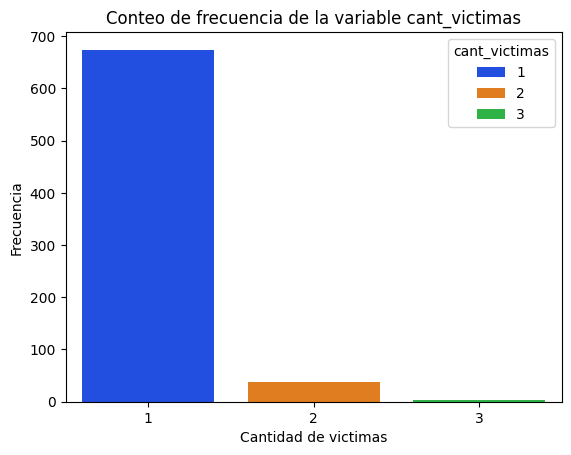

In [70]:
grafico_frecuencias(df,'cant_victimas','Cantidad de victimas')

Con el tipo de variable *datetime* se puede analizar mas fácilmente las fechas y los periodos típicos.

In [74]:
df['semestre'] = (df['fecha'].dt.month - 1) // 6 + 1

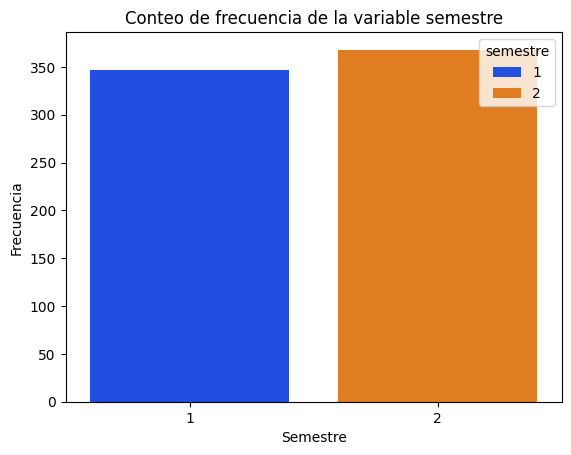

In [75]:
grafico_frecuencias(df,'semestre','Semestre')

In [54]:
df['trimestre']=df['fecha'].dt.quarter

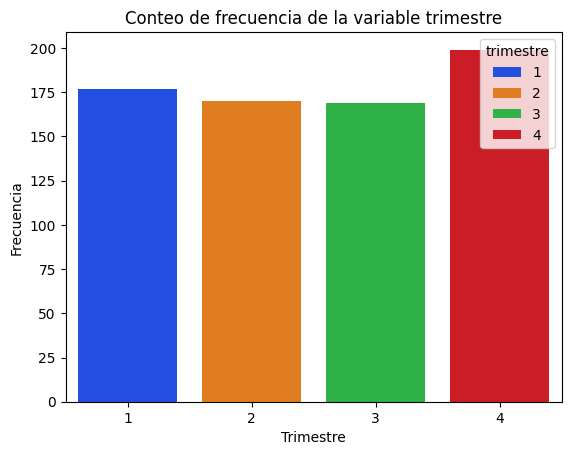

In [71]:
grafico_frecuencias(df,'trimestre','Trimestre')

In [76]:
df['bimestre'] = ((df['fecha'].dt.month - 1) // 2) + 1

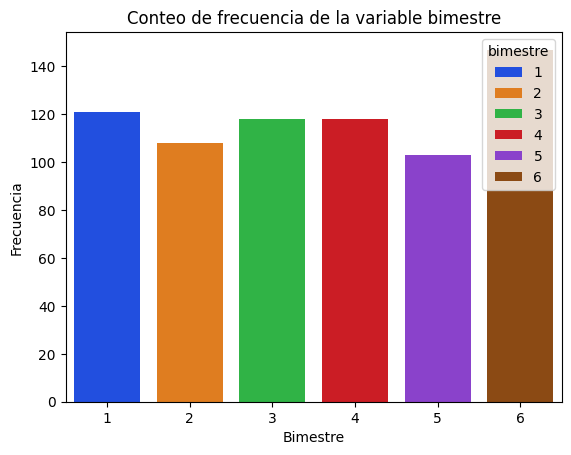

In [77]:
grafico_frecuencias(df,'bimestre','Bimestre')

<Axes: xlabel='fecha', ylabel='count'>

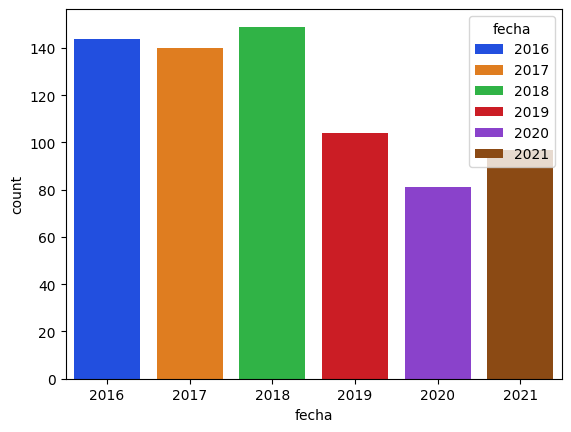

In [44]:
sns.countplot(data=df,x=df['fecha'].dt.year,hue=df['fecha'].dt.year,palette='bright')

In [ ]:
df['fecha'].dt.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Enero'),
  Text(1, 0, 'Febrero'),
  Text(2, 0, 'Marzo'),
  Text(3, 0, 'Abril'),
  Text(4, 0, 'Mayo'),
  Text(5, 0, 'Junio'),
  Text(6, 0, 'Julio'),
  Text(7, 0, 'Agosto'),
  Text(8, 0, 'Septiembre'),
  Text(9, 0, 'Octubre'),
  Text(10, 0, 'Noviembre'),
  Text(11, 0, 'Diciembre')])

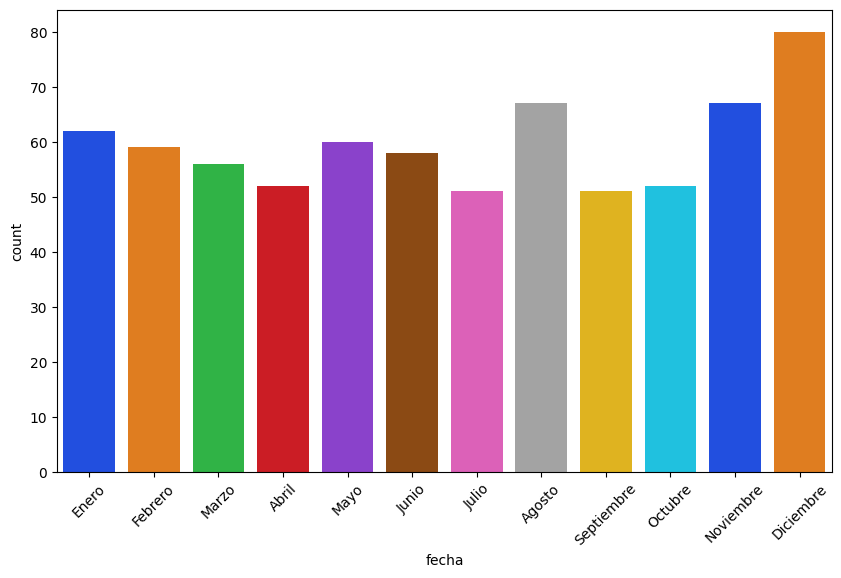

In [51]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df,x=df['fecha'].dt.month_name(locale='es'),hue=df['fecha'].dt.month_name('es'),palette='bright')
plt.xticks(fontsize=10, rotation=45)

<Axes: xlabel='fecha', ylabel='count'>

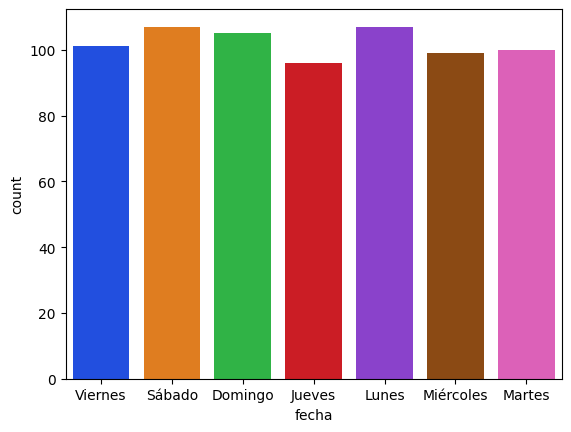

In [42]:
sns.countplot(data=df,x=df['fecha'].dt.day_name(locale='es'),hue=df['fecha'].dt.day_name(locale='es'),palette='bright')